In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# https://youtu.be/nbRkLE2fiVI
# https://youtu.be/1HqjPqNglPc
"""
Single Image Super-Resolution Using SRGAN
Original paper: https://arxiv.org/pdf/1609.04802.pdf
Dataset from:
    http://press.liacs.nl/mirflickr/mirdownload.html
    
All images resized to 128x128 to represent HR and 32x32 to represent LR.
"""

import tensorflow as tf
from tensorflow import keras
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

#########################################################################

#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from tensorflow.keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

###################################################################################

#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=5000
lr_list = os.listdir("data/lr_train")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("data/lr_train/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("data/hr_train")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("data/hr_train/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


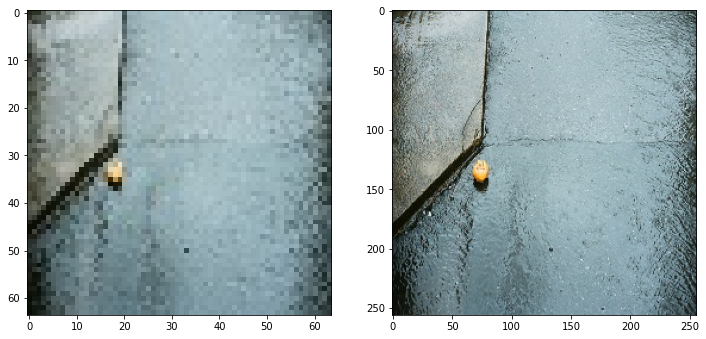

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 64, 64, 64)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       p_re_lu[0][0]                    
______________________________________________________________________________________________

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_33 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 128, 128)     7385

100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:50:08<00:00, 31.62s/it]


epoch: 1 g_loss: 83.39176424382406 d_loss: [6.52127736 0.90774522]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:50:11<00:00, 31.63s/it]


epoch: 2 g_loss: 41.119778500789664 d_loss: [2.70394087 0.88830742]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:49:58<00:00, 31.57s/it]


epoch: 3 g_loss: 34.94442805605072 d_loss: [0.57863111 0.92852871]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:49:46<00:00, 31.51s/it]


epoch: 4 g_loss: 32.4938210391542 d_loss: [0.2961675 0.9514055]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:49:45<00:00, 31.51s/it]


epoch: 5 g_loss: 31.103465550253837 d_loss: [0.54801885 0.95454545]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:51:00<00:00, 31.87s/it]


epoch: 6 g_loss: 30.111990184875197 d_loss: [0.16682082 0.98340311]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:51:09<00:00, 31.91s/it]


epoch: 7 g_loss: 29.999388918351897 d_loss: [0.11387729 0.9881878 ]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:35<00:00, 32.90s/it]


epoch: 8 g_loss: 28.964791594509872 d_loss: [0.13223867 0.98788876]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:53:54<00:00, 32.70s/it]


epoch: 9 g_loss: 28.087399021860517 d_loss: [0.01538272 0.99865431]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:57:51<00:00, 33.84s/it]


epoch: 10 g_loss: 27.566404716820237 d_loss: [0.01174555 0.99895335]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:58:47<00:00, 34.10s/it]


epoch: 11 g_loss: 27.099112880286988 d_loss: [0.61478265 0.96755383]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:55:39<00:00, 33.20s/it]


epoch: 12 g_loss: 26.626164869828656 d_loss: [0.73650716 0.97861842]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:12<00:00, 32.79s/it]


epoch: 13 g_loss: 26.235346105110132 d_loss: [0.58100905 0.98848684]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:41<00:00, 32.92s/it]


epoch: 14 g_loss: 25.94904806511254 d_loss: [0.02551793 0.99880383]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:45<00:00, 32.94s/it]


epoch: 15 g_loss: 25.881580955103825 d_loss: [0.45940163 0.99207536]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:38<00:00, 32.91s/it]


epoch: 16 g_loss: 25.429218082336718 d_loss: [0.06757191 0.99865431]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:55:06<00:00, 33.04s/it]


epoch: 17 g_loss: 24.834630400370184 d_loss: [0.92730746 0.9881878 ]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:55:18<00:00, 33.10s/it]


epoch: 18 g_loss: 3334.234451768501 d_loss: [2.52195059 0.97816986]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:55:07<00:00, 33.05s/it]


epoch: 19 g_loss: 121.10073626212527 d_loss: [0.00200896 0.99985048]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:55:17<00:00, 33.10s/it]


epoch: 20 g_loss: 113.69595869876551 d_loss: [5.14380233e-15 1.00000000e+00]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:57:54<00:00, 33.85s/it]


epoch: 21 g_loss: 112.76341112492757 d_loss: [5.14380233e-15 1.00000000e+00]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:57:32<00:00, 33.75s/it]


epoch: 22 g_loss: 104.42826781204442 d_loss: [5.14380233e-15 1.00000000e+00]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:58:21<00:00, 33.98s/it]


epoch: 23 g_loss: 97.70217103364935 d_loss: [5.14380233e-15 1.00000000e+00]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [2:12:51<00:00, 38.14s/it]


epoch: 24 g_loss: 86.81490619787189 d_loss: [0.05025749 0.99910287]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:56:21<00:00, 33.40s/it]


epoch: 25 g_loss: 77.25180252659264 d_loss: [0.29597146 0.99671053]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:45<00:00, 32.94s/it]


epoch: 26 g_loss: 68.64271914103385 d_loss: [1.04265728 0.99132775]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:35<00:00, 32.90s/it]


epoch: 27 g_loss: 64.45757081976348 d_loss: [0.18013208 0.99925239]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:37<00:00, 32.91s/it]


epoch: 28 g_loss: 58.76054081163908 d_loss: [0.02257857 0.99985048]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:40<00:00, 32.92s/it]


epoch: 29 g_loss: 52.319828307229365 d_loss: [0.02421006 0.99970096]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:40<00:00, 32.92s/it]


epoch: 30 g_loss: 50.53940010983408 d_loss: [0.16997069 0.99895335]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:37<00:00, 32.91s/it]


epoch: 31 g_loss: 47.83814204822887 d_loss: [0. 1.]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:33<00:00, 32.89s/it]


epoch: 32 g_loss: 45.04628119400243 d_loss: [0. 1.]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:42<00:00, 32.93s/it]


epoch: 33 g_loss: 44.51451207576186 d_loss: [7.60466288e-04 9.99850478e-01]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:42<00:00, 32.93s/it]


epoch: 34 g_loss: 42.526647987548245 d_loss: [0.12056478 0.99895335]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:50<00:00, 32.97s/it]


epoch: 35 g_loss: 41.949133822792454 d_loss: [0. 1.]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:55:42<00:00, 33.22s/it]


epoch: 36 g_loss: 41.31074345054809 d_loss: [0. 1.]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [2:03:28<00:00, 35.45s/it]


epoch: 37 g_loss: 39.74159257149582 d_loss: [0. 1.]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:55:18<00:00, 33.10s/it]


epoch: 38 g_loss: 43.87143897097647 d_loss: [0. 1.]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:47<00:00, 32.96s/it]


epoch: 39 g_loss: 40.700620605614766 d_loss: [0. 1.]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:42<00:00, 32.93s/it]


epoch: 40 g_loss: 39.56601050709994 d_loss: [0. 1.]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:38<00:00, 32.91s/it]


epoch: 41 g_loss: 38.14705337633927 d_loss: [2.84536409 0.99476675]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:38<00:00, 32.91s/it]


epoch: 42 g_loss: 38.242490512902656 d_loss: [0.44694395 0.99895335]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:41<00:00, 32.93s/it]


epoch: 43 g_loss: 37.46154763253682 d_loss: [0.02211386 0.99985048]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:37<00:00, 32.91s/it]


epoch: 44 g_loss: 37.70774802066493 d_loss: [0. 1.]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:54:45<00:00, 32.94s/it]


epoch: 45 g_loss: 36.717958751477696 d_loss: [0. 1.]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:57:06<00:00, 33.62s/it]


epoch: 46 g_loss: 36.08787681725607 d_loss: [0. 1.]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [2:03:13<00:00, 35.37s/it]


epoch: 47 g_loss: 35.92835048511268 d_loss: [0.38074363 0.99895335]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [2:14:56<00:00, 38.74s/it]


epoch: 48 g_loss: 36.544608403621105 d_loss: [0.10113649 0.99970096]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [2:06:19<00:00, 36.27s/it]


epoch: 49 g_loss: 34.847343253176746 d_loss: [4.4952549  0.99342105]


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [1:55:07<00:00, 33.05s/it]

epoch: 50 g_loss: 35.03218528528533 d_loss: [0.07654421 0.99970096]


In [3]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (64, 64, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (256, 256, 3)))
plt.show()

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((256,256,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 16  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 50
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)


In [10]:
if (e+1) % 50 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_mid"+ str(e+1) +".h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


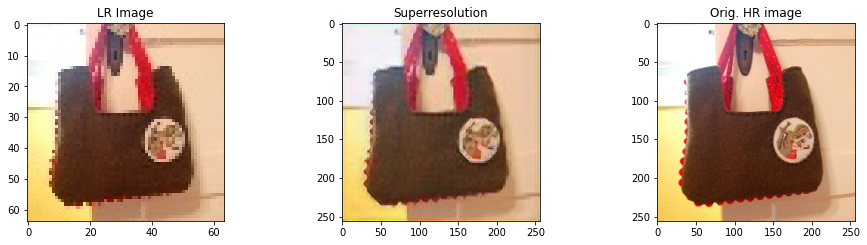

In [11]:
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_mid50.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1) 
src_image, tar_image = X1[ix], X2[ix] 


# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()




In [6]:
src_image.shape

(1, 64, 64, 3)

In [7]:
gen_image.shape

(1, 256, 256, 3)

In [8]:
import cv2
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio

#img1 = cv2.imread('imgPred0.png')
#img2 = cv2.imread('imgPred01.png')

img1 = tar_image
img2 = gen_image

MSE = mean_squared_error(img1, img2)
PSNR = peak_signal_noise_ratio(img1, img2)

print('MSE: ', MSE)
print('PSNR: ', PSNR)

MSE:  0.005357832217396431
PSNR:  22.710108906157917


C:\Users\z1061\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  if sys.path[0] == '':


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


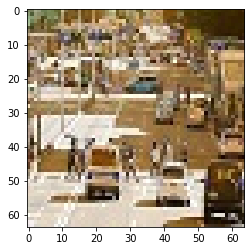

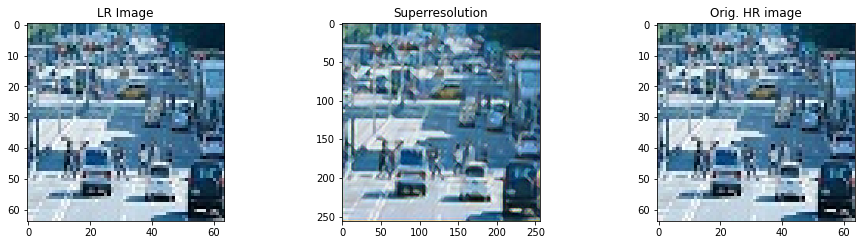

In [70]:
import matplotlib.pyplot as plt

lr = cv2.imread('C://pythonwork/SRGAN/data/testimg/12.jpg',1)
hr = cv2.imread('C://pythonwork/SRGAN/data/testimg/12.jpg',1)

plt.imshow(lr)
#cv2.imshow('imshow',lr)
#cv2.waitKey(0)

#cv2.destroyAllWindows()
################################################
#lr = cv2.imread('data_sp1.jpg',1)
#hr = cv2.imread('test.jpg',1)

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sr_lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
sr_hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)

sr_lr = sr_lr / 255.
sr_hr = sr_hr / 255.

sr_lr = np.expand_dims(sr_lr, axis=0)
sr_hr = np.expand_dims(sr_hr, axis=0)

generated_sr_hr = generator.predict(sr_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sr_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sr_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sr_hr[0,:,:,:])

plt.show()

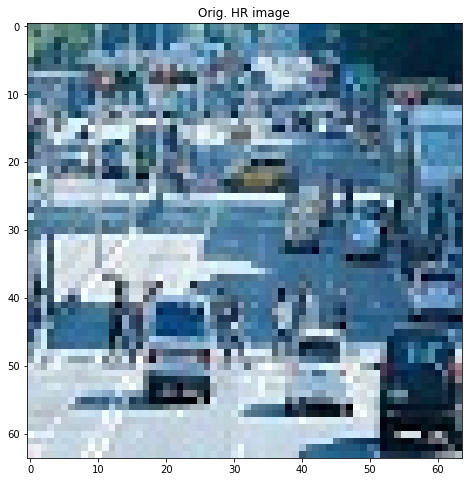

In [71]:
plt.figure(figsize=(16, 8))
plt.title('Orig. HR image')
plt.imshow(sr_hr[0,:,:,:])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


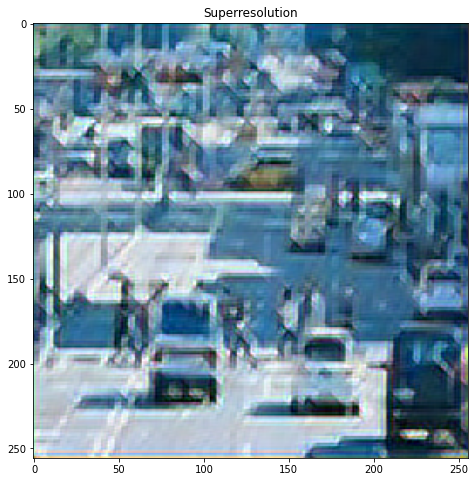

In [72]:
plt.figure(figsize=(16, 8))
plt.title('Superresolution')
plt.imshow(generated_sr_hr[0,:,:,:])

plt.show()

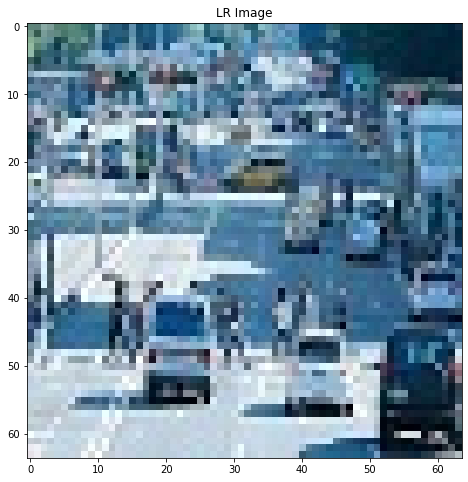

In [74]:
plt.figure(figsize=(16, 8))
plt.title('LR Image')
plt.imshow(sr_lr[0,:,:,:])

plt.show()

In [ ]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import os
from glob import glob
from natsort import natsorted


target_dir = 'C://pythonwork/SRGAN/data/d_image/set5/sosrgan/hr'  # 标签图像（lable 、 ground-truth）存放路径
target_files = natsorted(glob(os.path.join(target_dir, '*.png')) + glob(os.path.join(target_dir, '*.jpg')))  # 标签图像（lable 、 ground-truth）名字的后缀

test_result_dir = 'C://pythonwork/SRGAN/data/d_image/set5/sosrgan/gn'  # 预测图像（prediction、test、增强图像）存放路径
test_result_files = natsorted(glob(os.path.join(test_result_dir, '*.png')) + glob(os.path.join(test_result_dir, '*.jpg')))  # 预测图像（prediction、test、增强图像）名字的后缀


psnr_total = 0
ssim_total = 0
for i in range(0, len(target_files)):
    img1 = cv2.imread(target_files[i])
    img2 = cv2.imread(test_result_files[i])
    p = psnr(img1, img2)
    s = ssim(img1, img2, multichannel=True)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    print(p)
    # s = ssim(img1, img2)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    m = mse(img1, img2)

    psnr_total = p + psnr_total
    ssim_total = s + ssim_total

mean_psnr = psnr_total/len(target_files)
mean_ssim = ssim_total/len(target_files)
print('平均psnr的值为：',mean_psnr)
print('平均ssim的值为：',mean_ssim)

In [ ]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import os
from glob import glob
from natsort import natsorted


target_dir = 'C://pythonwork/SRGAN/data/d_image/set5/srgan/hr'  # 标签图像（lable 、 ground-truth）存放路径
target_files = natsorted(glob(os.path.join(target_dir, '*.png')) + glob(os.path.join(target_dir, '*.jpg')))  # 标签图像（lable 、 ground-truth）名字的后缀

test_result_dir = 'C://pythonwork/SRGAN/data/d_image/set5/srgan/gn'  # 预测图像（prediction、test、增强图像）存放路径
test_result_files = natsorted(glob(os.path.join(test_result_dir, '*.png')) + glob(os.path.join(test_result_dir, '*.jpg')))  # 预测图像（prediction、test、增强图像）名字的后缀


psnr_total = 0
ssim_total = 0
for i in range(0, len(target_files)):
    img1 = cv2.imread(target_files[i])
    img2 = cv2.imread(test_result_files[i])
    p = psnr(img1, img2)
    s = ssim(img1, img2, multichannel=True)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    print(p)
    # s = ssim(img1, img2)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    m = mse(img1, img2)

    psnr_total = p + psnr_total
    ssim_total = s + ssim_total

mean_psnr = psnr_total/len(target_files)
mean_ssim = ssim_total/len(target_files)
print('平均psnr的值为：',mean_psnr)
print('平均ssim的值为：',mean_ssim)

In [ ]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import os
from glob import glob
from natsort import natsorted


target_dir = 'C://pythonwork/SRGAN/data/d_image/set5/Set5_hr'  # 标签图像（lable 、 ground-truth）存放路径
target_files = natsorted(glob(os.path.join(target_dir, '*.png')) + glob(os.path.join(target_dir, '*.jpg')))  # 标签图像（lable 、 ground-truth）名字的后缀

test_result_dir = 'C://pythonwork/SRGAN/data/d_image/set5/esrgan'  # 预测图像（prediction、test、增强图像）存放路径
test_result_files = natsorted(glob(os.path.join(test_result_dir, '*.png')) + glob(os.path.join(test_result_dir, '*.jpg')))  # 预测图像（prediction、test、增强图像）名字的后缀


psnr_total = 0
ssim_total = 0
for i in range(0, len(target_files)):
    img1 = cv2.imread(target_files[i])
    img2 = cv2.imread(test_result_files[i])
    p = psnr(img1, img2)
    s = ssim(img1, img2, multichannel=True)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    print(p)
    # s = ssim(img1, img2)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    m = mse(img1, img2)

    psnr_total = p + psnr_total
    ssim_total = s + ssim_total

mean_psnr = psnr_total/len(target_files)
mean_ssim = ssim_total/len(target_files)
print('平均psnr的值为：',mean_psnr)
print('平均ssim的值为：',mean_ssim)


In [ ]:
lr = cv2.imread('C://pythonwork/SRGAN/data/lr_images/im58.jpg',1)
hr = cv2.imread('C://pythonwork/SRGAN/data/hr_images/im58.jpg',1)

plt.imshow(lr)
#cv2.imshow('imshow',lr)
#cv2.waitKey(0)

#cv2.destroyAllWindows()
################################################
#lr = cv2.imread('data_sp1.jpg',1)
#hr = cv2.imread('test.jpg',1)

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sr_lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
sr_hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)

sr_lr = sr_lr / 255.
sr_hr = sr_hr / 255.

sr_lr = np.expand_dims(sr_lr, axis=0)
sr_hr = np.expand_dims(sr_hr, axis=0)

generated_sr_hr = generator.predict(sr_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sr_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sr_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sr_hr[0,:,:,:])

plt.show()

In [ ]:
plt.figure(figsize=(16, 8))

plt.title('Superresolution')
plt.imshow(sr_hr[0,:,:,:])


plt.show()

In [ ]:
plt.figure(figsize=(16, 8))

plt.title('Superresolution')
plt.imshow(generated_sr_hr[0,:,:,:])


plt.show()

In [ ]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import os
from glob import glob
from natsort import natsorted


target_dir = 'C://pythonwork/SRGAN/data/result/ortest/HR1'  # 标签图像（lable 、 ground-truth）存放路径
target_files = natsorted(glob(os.path.join(target_dir, '*.png')) + glob(os.path.join(target_dir, '*.jpg')))  # 标签图像（lable 、 ground-truth）名字的后缀

test_result_dir = 'C://pythonwork/SRGAN/data/result/ortest/gan1'  # 预测图像（prediction、test、增强图像）存放路径
test_result_files = natsorted(glob(os.path.join(test_result_dir, '*.png')) + glob(os.path.join(test_result_dir, '*.jpg')))  # 预测图像（prediction、test、增强图像）名字的后缀


psnr_total = 0
ssim_total = 0
for i in range(0, len(target_files)):
    img1 = cv2.imread(target_files[i])
    img2 = cv2.imread(test_result_files[i])
    p = psnr(img1, img2)
    s = ssim(img1, img2, multichannel=True)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    print(p)
    # s = ssim(img1, img2)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    m = mse(img1, img2)

    psnr_total = p + psnr_total
    ssim_total = s + ssim_total

mean_psnr = psnr_total/len(target_files)
mean_ssim = ssim_total/len(target_files)
print('平均psnr的值为：',mean_psnr)
print('平均ssim的值为：',mean_ssim)

In [ ]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import os
from glob import glob
from natsort import natsorted


target_dir = 'C://pythonwork/SRGAN/data/result/ortest/HR1'  # 标签图像（lable 、 ground-truth）存放路径
target_files = natsorted(glob(os.path.join(target_dir, '*.png')) + glob(os.path.join(target_dir, '*.jpg')))  # 标签图像（lable 、 ground-truth）名字的后缀

test_result_dir = 'C://pythonwork/SRGAN/data/result/ortest/gan1'  # 预测图像（prediction、test、增强图像）存放路径
test_result_files = natsorted(glob(os.path.join(test_result_dir, '*.png')) + glob(os.path.join(test_result_dir, '*.jpg')))  # 预测图像（prediction、test、增强图像）名字的后缀


psnr_total = 0
ssim_total = 0
for i in range(0, len(target_files)):
    img1 = cv2.imread(target_files[i])
    img2 = cv2.imread(test_result_files[i])
    p = psnr(img1, img2)
    s = ssim(img1, img2, multichannel=True)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    print(p)
    # s = ssim(img1, img2)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    m = mse(img1, img2)

    psnr_total = p + psnr_total
    ssim_total = s + ssim_total

mean_psnr = psnr_total/len(target_files)
mean_ssim = ssim_total/len(target_files)
print('平均psnr的值为：',mean_psnr)
print('平均ssim的值为：',mean_ssim)


In [ ]:
lr = cv2.imread('C://pythonwork/SRGAN/data/lr_images/im131.jpg',1)
hr = cv2.imread('C://pythonwork/SRGAN/data/hr_images/im131.jpg',1)

plt.imshow(lr)
#cv2.imshow('imshow',lr)
#cv2.waitKey(0)

#cv2.destroyAllWindows()
################################################
#lr = cv2.imread('data_sp1.jpg',1)
#hr = cv2.imread('test.jpg',1)

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sr_lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
sr_hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)

sr_lr = sr_lr / 255.
sr_hr = sr_hr / 255.

sr_lr = np.expand_dims(sr_lr, axis=0)
sr_hr = np.expand_dims(sr_hr, axis=0)

generated_sr_hr = generator.predict(sr_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sr_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sr_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sr_hr[0,:,:,:])

plt.show()

In [ ]:
plt.figure(figsize=(16, 8))

plt.title('Superresolution')
plt.imshow(generated_sr_hr[0,:,:,:])


plt.show()
plt.figure(figsize=(16, 8))

plt.title('Superresolution')
plt.imshow(sr_hr[0,:,:,:])


plt.show()

In [ ]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import os
from glob import glob
from natsort import natsorted


target_dir = 'C://pythonwork/SRGAN/data/result/ortest/HR3'  # 标签图像（lable 、 ground-truth）存放路径
target_files = natsorted(glob(os.path.join(target_dir, '*.png')) + glob(os.path.join(target_dir, '*.jpg')))  # 标签图像（lable 、 ground-truth）名字的后缀

test_result_dir = 'C://pythonwork/SRGAN/data/result/ortest/gan3'  # 预测图像（prediction、test、增强图像）存放路径
test_result_files = natsorted(glob(os.path.join(test_result_dir, '*.png')) + glob(os.path.join(test_result_dir, '*.jpg')))  # 预测图像（prediction、test、增强图像）名字的后缀


psnr_total = 0
ssim_total = 0
for i in range(0, len(target_files)):
    img1 = cv2.imread(target_files[i])
    img2 = cv2.imread(test_result_files[i])
    p = psnr(img1, img2)
    s = ssim(img1, img2, multichannel=True)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    print(p)
    # s = ssim(img1, img2)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    m = mse(img1, img2)

    psnr_total = p + psnr_total
    ssim_total = s + ssim_total

mean_psnr = psnr_total/len(target_files)
mean_ssim = ssim_total/len(target_files)
print('平均psnr的值为：',mean_psnr)
print('平均ssim的值为：',mean_ssim)

In [ ]:
lr = cv2.imread('C://pythonwork/SRGAN/data/testimg/lr/test1.jpg',1)
hr = cv2.imread('C://pythonwork/SRGAN/data/testimg/hr/test1.jpg',1)

plt.imshow(lr)
#cv2.imshow('imshow',lr)
#cv2.waitKey(0)

#cv2.destroyAllWindows()
################################################
#lr = cv2.imread('data_sp1.jpg',1)
#hr = cv2.imread('test.jpg',1)

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sr_lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
sr_hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)

sr_lr = sr_lr / 255.
sr_hr = sr_hr / 255.

sr_lr = np.expand_dims(sr_lr, axis=0)
sr_hr = np.expand_dims(sr_hr, axis=0)

generated_sr_hr = generator.predict(sr_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sr_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sr_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sr_hr[0,:,:,:])

plt.show()

In [ ]:
plt.figure(figsize=(16, 8))

plt.title('Superresolution')
plt.imshow(generated_sr_hr[0,:,:,:])

plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Orig. HR image')
plt.imshow(sr_hr[0,:,:,:])

plt.show()

In [ ]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import os
from glob import glob
from natsort import natsorted


target_dir = 'C://pythonwork/SRGAN/data/result/ortest/HR2'  # 标签图像（lable 、 ground-truth）存放路径
target_files = natsorted(glob(os.path.join(target_dir, '*.png')) + glob(os.path.join(target_dir, '*.jpg')))  # 标签图像（lable 、 ground-truth）名字的后缀

test_result_dir = 'C://pythonwork/SRGAN/data/result/ortest/gan2'  # 预测图像（prediction、test、增强图像）存放路径
test_result_files = natsorted(glob(os.path.join(test_result_dir, '*.png')) + glob(os.path.join(test_result_dir, '*.jpg')))  # 预测图像（prediction、test、增强图像）名字的后缀


psnr_total = 0
ssim_total = 0
for i in range(0, len(target_files)):
    img1 = cv2.imread(target_files[i])
    img2 = cv2.imread(test_result_files[i])
    p = psnr(img1, img2)
    s = ssim(img1, img2, multichannel=True)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    print(p)
    # s = ssim(img1, img2)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    m = mse(img1, img2)

    psnr_total = p + psnr_total
    ssim_total = s + ssim_total

mean_psnr = psnr_total/len(target_files)
mean_ssim = ssim_total/len(target_files)
print('平均psnr的值为：',mean_psnr)
print('平均ssim的值为：',mean_ssim)

In [ ]:
import cv2
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio

#img1 = cv2.imread('imgPred0.png')
#img2 = cv2.imread('imgPred01.png')

img11 = sr_hr
img22 = generated_sr_hr

MSE = mean_squared_error(img11, img22)
PSNR = peak_signal_noise_ratio(img11, img22)

print('MSE: ', MSE)
print('PSNR: ', PSNR)

In [ ]:
lr = cv2.imread('C://pythonwork/SRGAN/data/testimg/lr/data_gasuss1.jpg',1)
hr = cv2.imread('C://pythonwork/SRGAN/data/testimg/hr/data_gasuss1.jpg',1)

plt.imshow(lr)
#cv2.imshow('imshow',lr)
#cv2.waitKey(0)

#cv2.destroyAllWindows()
################################################
#lr = cv2.imread('data_sp1.jpg',1)
#hr = cv2.imread('test.jpg',1)

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sr_lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
sr_hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)

sr_lr = sr_lr / 255.
sr_hr = sr_hr / 255.

sr_lr = np.expand_dims(sr_lr, axis=0)
sr_hr = np.expand_dims(sr_hr, axis=0)

generated_sr_hr = generator.predict(sr_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sr_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sr_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sr_hr[0,:,:,:])

plt.show()

In [ ]:
lr = cv2.imread('C://pythonwork/SRGAN/data/testimg/lr/data_sp1.jpg',1)
hr = cv2.imread('C://pythonwork/SRGAN/data/testimg/hr/data_sp1.jpg',1)

plt.imshow(lr)
#cv2.imshow('imshow',lr)
#cv2.waitKey(0)

#cv2.destroyAllWindows()
################################################
#lr = cv2.imread('data_sp1.jpg',1)
#hr = cv2.imread('test.jpg',1)

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sr_lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
sr_hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)

sr_lr = sr_lr / 255.
sr_hr = sr_hr / 255.

sr_lr = np.expand_dims(sr_lr, axis=0)
sr_hr = np.expand_dims(sr_hr, axis=0)

generated_sr_hr = generator.predict(sr_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sr_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sr_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sr_hr[0,:,:,:])

plt.show()

#cv2.imshow('imshow',sr_lr)
#cv2.waitKey(0)
#cv2.destroyAllWindows()